In [1]:
%config IPCompleter.greedy=True


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn import manifold
import joblib

%matplotlib inline

In [3]:
mnist_train_file = "https://pjreddie.com/media/files/mnist_train.csv"
mnist_test_file = "https://pjreddie.com/media/files/mnist_test.csv"

Each row of the CSV consists of the label of the image and 784 pixel values(28x28) ranging from 0 to 255. The dataset consists of 60000 images in this format.
First column is label and  rest of them are pixel

In [4]:
cols =["label"]
cols.extend([f'{i}x{j}' for i in range(28) for j in range(28)])
mnist_train_df = pd.read_csv(mnist_train_file , names = cols)

In [5]:
mnist_train_df.describe()

,label,0x0,0x1,0x2,0x3,0x4,0x5,0x6,0x7,0x8,...,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


In [6]:
mnist_train_df.head()

,label,0x0,0x1,0x2,0x3,0x4,0x5,0x6,0x7,0x8,...,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


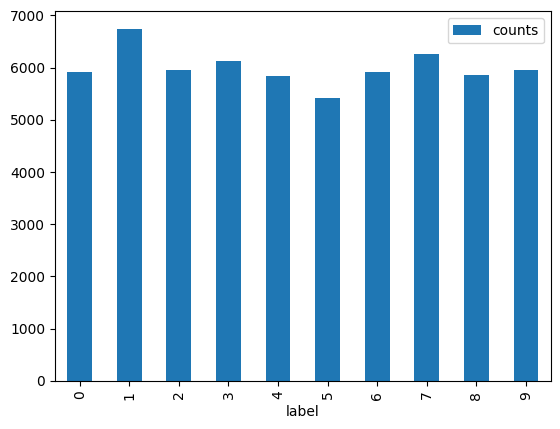

In [7]:
mnist_train_df.groupby(['label'])\
   .apply(lambda df: df.shape[0])\
   .reset_index()\
   .rename(columns = {0:'counts'})\
   .plot.bar(x = 'label', y='counts')

In [8]:
def create_folds(df):
    data = df.copy()

    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1

    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    #There are several choices for selecting the appropriate number of bins. If
    #you have a lot of samples( > 10k, > 100k), then you don’t need to care about the
    #number of bins. Just divide the data into 10 or 20 bins. If you DO NOT have a lot of
    #samples, you can use a simple rule like Sturge’s Rule to calculate the appropriate
    #number of bins. #Number of bins = 1 + log2(N)

    # calculate the number of bins by Sturge's rule. I take the floor of the value, 
    # you can also just round it
    # num_bins = int(np.floor(1 + np.log2(len(data))))

    # bin targets
    # data.loc[:, "bins"] = pd.cut(data["target"], bins=num_bins, labels=False)

    # initiate the kfold class from model_selection module
    kf = sklearn.model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.label.values)):
        data.loc[v_, 'kfold'] = f

    # drop the bins column
    # data = data.drop("bins", axis=1)
    # return dataframe with folds
    return data


In [9]:
df_with_folds = create_folds(mnist_train_df)

In [10]:
df_with_folds.head()

,label,0x0,0x1,0x2,0x3,0x4,0x5,0x6,0x7,0x8,...,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,kfold
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def run(fold, df, model = None):
   
    # training data is where kfold is not equal to provided fold
    # also, note that we reset the index
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # validation data is where kfold is equal to provided fold
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # drop the label column from dataframe and convert it to
    # a numpy array by using .values.
    # target is label column in the dataframe
    x_train = df_train.drop("label", axis=1).values
    y_train = df_train.label.values

    # similarly, for validation, we have
    x_valid = df_valid.drop("label", axis=1).values
    y_valid = df_valid.label.values

    #We can have any model
    clf = None
    if model is None:
        clf = sklearn.tree.DecisionTreeClassifier()
    elif model == "gini":
        clf = sklearn.tree.DecisionTreeClassifier(criterion="gini")
    elif model == "entropy":
        clf = sklearn.tree.DecisionTreeClassifier(criterion="entropy")
    elif model == "rf":
        from sklearn import  ensemble
        clf  = sklearn.ensemble.RandomForestClassifier()
    else:
        raise Exception("Invalid model")
        

    # fit the model on training data
    clf.fit(x_train, y_train)

    # create predictions for validation samples
    preds = clf.predict(x_valid)

    # calculate & print accuracy
    accuracy = sklearn.metrics.accuracy_score(y_valid, preds)
    print(f"Fold={fold}, Accuracy={accuracy}")
    
    # save the model
    joblib.dump(clf, f"../models/dt_{fold}_{model}.bin")
    

In [12]:
# Run same model on different folds
for fold in range(5):
    run(fold, df_with_folds, "gini")

Fold=0, Accuracy=0.86725
Fold=1, Accuracy=0.8679166666666667
Fold=2, Accuracy=0.86825
Fold=3, Accuracy=0.872
Fold=4, Accuracy=0.8699166666666667


In [13]:
# Run same model on different folds
for fold in range(5):
    run(fold, df_with_folds, "entropy")

Fold=0, Accuracy=0.8786666666666667
Fold=1, Accuracy=0.8710833333333333
Fold=2, Accuracy=0.8774166666666666
Fold=3, Accuracy=0.8800833333333333
Fold=4, Accuracy=0.8734166666666666


In [14]:
# Run same model on different folds
for fold in range(5):
    run(fold, df_with_folds, "rf")

Fold=0, Accuracy=0.96825
Fold=1, Accuracy=0.9634166666666667
Fold=2, Accuracy=0.9685833333333334
Fold=3, Accuracy=0.9680833333333333
Fold=4, Accuracy=0.96375
